# MODELO NO SUPERVISADO

## IMPORTACIÓN DE PAQUETES

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


'''#Autocompletado
%config IPCompleter.greedy = True'''

#Desactivar la posición científica
pd.options.display.float_format = '{:.2f}'.format

#Desactivar warnings
import warnings
warnings.filterwarnings('ignore')

## IMPORTACIÓN DE DATOS

In [126]:
df = pd.read_pickle('../../02_Datos/03_Trabajo/df_tablon.pickle')

In [127]:
df.columns

Index(['stg', 'scg', 'str', 'lpr', 'peg', 'level'], dtype='object')

In [128]:
#Dejamos unicamente las variables predictoras del modelo supervisado de clasificación.
variables_eliminar = ['level','stg', 'lpr', 'str']
#variables_eliminar = ['level']

x = df.drop(columns = variables_eliminar).copy()
y = df.level.copy()

## MODELIZAR 

### Crear el espacion de soluciones

In [129]:
min_k = 3
max_k = 6

soluciones = list(range(min_k,max_k))

### Crear listas para guardar la salida de cada métrica

In [130]:
codo = []
silueta = []
calins = []
davies = []


### Analizar el espacio de soluciones

In [131]:
for solucion in soluciones:
    #instanciar
    cluster = KMeans(n_clusters= solucion, n_init= 20)
    #Entrenar
    cluster.fit(x)
    #Recoger las métricas
    codo.append(cluster.inertia_)
    silueta.append(silhouette_score(x,cluster.labels_))
    calins.append(calinski_harabasz_score(x, cluster.labels_))
    davies.append(davies_bouldin_score(x, cluster.labels_))

### Identificar la mejor solución   

In [132]:
metricas = pd.DataFrame({'Solución':soluciones,
                        'Codo':codo,
                        'Silueta':silueta,
                        'Calins':calins,
                        'Davies':davies}).set_index('Solución')
metricas

,Codo,Silueta,Calins,Davies
Solución,,,,
3,9.16,0.47,266.07,0.76
4,6.38,0.47,290.42,0.72
5,5.29,0.44,274.88,0.77


### Analizar los gráficos

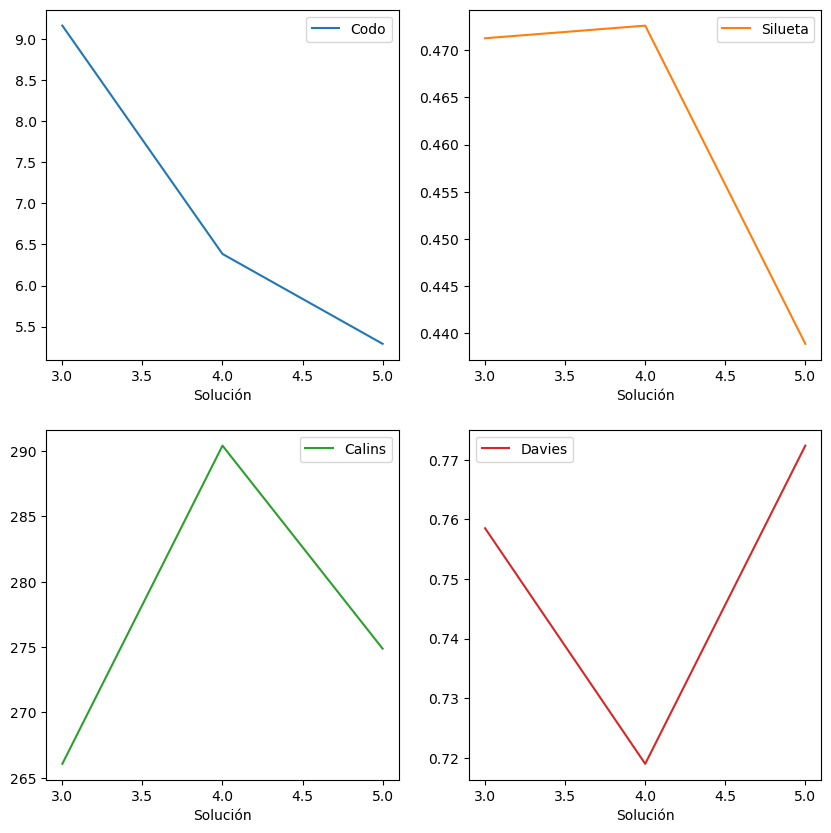

In [133]:
metricas.plot(subplots = True, figsize = (10,10), layout = (2,2), sharex = False);

### Conclusión

Revisado las diferentes métricas confirmamos que la mejor segmentación son k= 4

## SEGMENTACIÓN FINAL PARA KMEANS

In [134]:
mejor_solucion = 4
k=4
#Instanciar

cluster = KMeans(n_clusters= mejor_solucion, n_init=20)
#Entrenar
cluster.fit(x)
pred = cluster.labels_

### HOMOGENEIDAD DE LOS CLUSTERS

In [135]:
vis_y = y.value_counts().sort_index()
vis_pre = pd.Series(pred).value_counts().sort_index()
dif = vis_pre - vis_y
Homo_Int = 1-(abs(1 - (vis_pre / vis_y)))

temp = pd.DataFrame({'y':vis_y, 'pred':vis_pre, 'dif': dif, 'H_int':Homo_Int})
temp

,y,pred,dif,H_int
0,63,89,26,0.59
1,83,96,13,0.84
2,88,28,-60,0.32
3,24,45,21,0.12


In [136]:
print("Homogeniedad Global:",temp.H_int.mean())

Homogeniedad Global: 0.46846422486482725


### REPORTING DEL MODELO

ROC CHART MULTICLASS

In [138]:
# Binarizar las etiquetas verdaderas y las predicciones para cada clase
n_classes = len(np.unique(y))
binarized_val_y = label_binarize(y, classes=np.arange(n_classes))
binarized_pred = label_binarize(pred, classes=np.arange(n_classes))

#Calcular la curva ROC y el área bajo la curva (AUC)

0 0.6603174603174604
1 0.7941135972461275
2 0.4866310160427807
3 0.40384615384615385


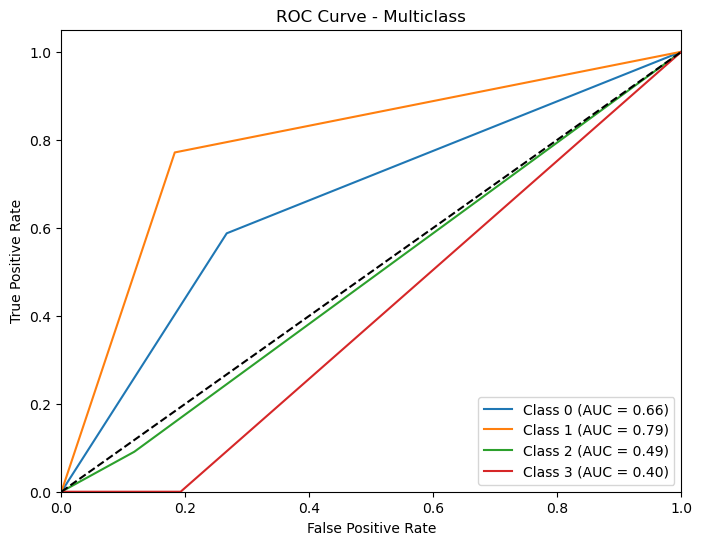

In [139]:
# Binarizar las etiquetas verdaderas y las predicciones para cada clase
n_classes = len(np.unique(y))
binarized_val_y = label_binarize(y, classes=np.arange(n_classes))
binarized_pred = label_binarize(pred, classes=np.arange(n_classes))

# Calcular la curva ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_val_y[:, i], binarized_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(i, roc_auc[i])

# Plotear el gráfico ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Configurar etiquetas y título del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend(loc="lower right");

### COMPARATIVA DE REALES VS. PREDICHAS

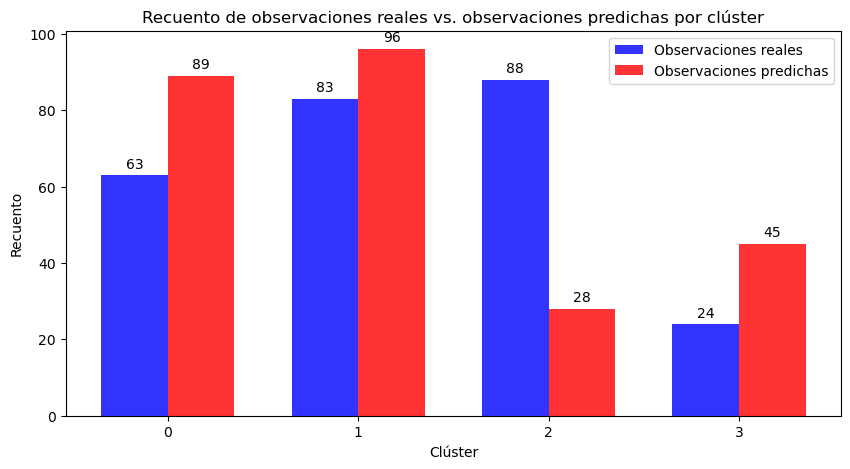

In [140]:
# Código previo para instanciar, entrenar y obtener las predicciones

# Crear DataFrame con los recuentos
df_counts = pd.DataFrame({'y': vis_y, 'pred': vis_pre, 'dif': dif}).T

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10,5))
x_labels = df_counts.columns
x = range(len(x_labels))

bar_width = 0.35
opacity = 0.8

bar1 = ax.bar(x, df_counts.iloc[0], bar_width, alpha=opacity, color='b', label='Observaciones reales')
bar2 = ax.bar(np.add(x, bar_width), df_counts.iloc[1], bar_width, alpha=opacity, color='r', label='Observaciones predichas')

# Etiquetas de las barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Desplazamiento de la etiqueta
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

# Etiquetas de los ejes y título del gráfico
ax.set_xlabel('Clúster')
ax.set_ylabel('Recuento')
ax.set_title('Recuento de observaciones reales vs. observaciones predichas por clúster')
ax.set_xticks(np.add(x, bar_width)-(bar_width/2))
ax.set_xticklabels(x_labels)
ax.legend()

# Mostrar el gráfico de barras
plt.show();